Define dataset:

In [ ]:
#@title Datasets
import os
import numpy as np
from PIL import Image
import scipy, scipy.io
from easydict import EasyDict
from collections import OrderedDict
from torch.utils.data import Dataset
from torchvision import datasets, transforms
import torchvision
import torch
import torch.distributions as tdist

class PointsDataset(Dataset):

    def __init__(self, num_classes = 4, width = 4, balanced = True):

        self.num_classes = num_classes
        self.width = width
        self.num_centers = int(np.sqrt(self.num_classes))
        self.x_centers = torch.linspace(-self.width, self.width, steps = self.num_centers)
        self.y_centers = torch.linspace(-self.width, self.width, steps = self.num_centers)
        self.centers = []
        self.center_label = []
        self.data = []
        self.label = []
        for i in range(self.num_centers):
            for j in range(self.num_centers):
                if balanced == False and self.x_centers[i]<0 and self.y_centers[j]<0:
                    continue
                else:
                    self.centers.append(torch.tensor([self.x_centers[i], self.y_centers[j]]))
                    self.center_label.append(i*self.num_centers + j)
        num_samples_per_class = 1000
        for i in range(len(self.centers)):
            n = tdist.Normal(self.centers[i], 0.1)
            self.data.append(n.sample((num_samples_per_class,)).numpy())
            self.label.extend([self.center_label[i]] *num_samples_per_class)
        if balanced == True:
            self.data = torch.tensor(self.data).reshape(num_samples_per_class*self.num_classes,2)/(self.width*2)
        else:
            self.data = torch.tensor(self.data).reshape(num_samples_per_class * int(self.num_classes*0.75), 2) / (self.width*2)
        print("max",self.data.max().item())
        print("min",self.data.min().item())
        self.label = torch.tensor(self.label)

    def __getitem__(self, index):

        return self.data[index], self.label[index]

    def __len__(self):

        return self.data.shape[0]

def get_metadata(name):
    if name == "points":
        metadata = EasyDict(
            {
                "image_size": 1,
                "num_classes": 4,
                "train_images": 400,
                "val_images": 400,
                "num_channels": 1,
                "balanced": True
            }
        )
    elif name == "points_imbalanced":
        metadata = EasyDict(
            {
                "image_size": 1,
                "num_classes": 4,
                "train_images": 400,
                "val_images": 400,
                "num_channels": 1,
                "balanced": False
            }
        )
    else:
        raise ValueError(f"{name} dataset nor supported!")
    return metadata

def get_dataset(name, data_dir, metadata):
    """
    Return a dataset with the current name. We only support two datasets with
    their fixed image resolutions. One can easily add additional datasets here.

    Note: To avoid learning the distribution of transformed data, don't use heavy
        data augmentation with diffusion models.
    """
    if name in ["points", "points_imbalanced"]:
        train_set = PointsDataset(num_classes=metadata.num_classes, balanced=metadata.balanced)

    else:
        raise ValueError(f"{name} dataset nor supported!")
    return train_set


def remove_module(d):
    return OrderedDict({(k[len("module.") :], v) for (k, v) in d.items()})


def fix_legacy_dict(d):
    keys = list(d.keys())
    if "model" in keys:
        d = d["model"]
    if "state_dict" in keys:
        d = d["state_dict"]
    keys = list(d.keys())
    # remove multi-gpu module.
    if "module." in keys[1]:
        d = remove_module(d)
    return d


Define NN architecture:

In [ ]:
#@title NN
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils import spectral_norm

class ConditionalLinear(nn.Module):
    def __init__(self, num_in, num_out, n_steps):
        super(ConditionalLinear, self).__init__()
        self.num_out = num_out
        self.lin = nn.Linear(num_in, num_out)
        self.embed = nn.Embedding(n_steps, num_out)
        self.embed.weight.data.uniform_()
        torch.nn.init.xavier_normal_(self.lin.weight)


    def forward(self, x, y):
        out = self.lin(x)
        gamma = self.embed(y)
        out = gamma.view(-1, self.num_out) * out
        return out

class SpectralConditionalLinear(nn.Module):
    def __init__(self, num_in, num_out, n_steps):
        super(SpectralConditionalLinear, self).__init__()
        self.num_out = num_out
        self.lin = spectral_norm(nn.Linear(num_in, num_out))
        self.embed = nn.Embedding(n_steps, num_out)
        self.embed.weight.data.uniform_()
        torch.nn.init.xavier_normal_(self.lin.weight)


    def forward(self, x, y):
        out = self.lin(x)
        gamma = self.embed(y)
        out = gamma.view(-1, self.num_out) * out
        return out


class ConditionalModel(nn.Module):
    def __init__(self, n_steps):
        super(ConditionalModel, self).__init__()
        self.lin1 = ConditionalLinear(2, 64, n_steps)
        self.lin2 = ConditionalLinear(64, 64, n_steps)
        self.lin3 = ConditionalLinear(64, 64, n_steps)
        self.lin4 = nn.Linear(64, 2)

    def forward(self, x, y):
        x = F.softplus(self.lin1(x, y))
        x = F.softplus(self.lin2(x, y))
        x = F.softplus(self.lin3(x, y))
        return self.lin4(x)

class SpectralConditionalModel(nn.Module):
    def __init__(self, n_steps):
        super(SpectralConditionalModel, self).__init__()
        self.lin1 = SpectralConditionalLinear(2, 64, n_steps)
        self.lin2 = SpectralConditionalLinear(64,64, n_steps)
        self.lin3 = SpectralConditionalLinear(64,64, n_steps)
        self.lin4 = spectral_norm(nn.Linear(64, 2))

    def forward(self, x, y):
        x = F.relu(self.lin1(x, y))
        x = F.relu(self.lin2(x, y))
        x = F.relu(self.lin3(x, y))
        return self.lin4(x)


class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.lin1 = nn.Linear(2, 128)
        self.lin2 = nn.Linear(128, 128)
        self.lin3 = nn.Linear(128, 128)
        self.lin4 = nn.Linear(128, 2)
        torch.nn.init.xavier_normal_(self.lin1.weight)
        torch.nn.init.xavier_normal_(self.lin2.weight)
        torch.nn.init.xavier_normal_(self.lin3.weight)
        torch.nn.init.xavier_normal_(self.lin4.weight)

    def forward(self, x):
        x = F.relu(self.lin1(x))
        x = F.relu(self.lin2(x))
        x = F.relu(self.lin3(x))
        return self.lin4(x)


Install pot in colab:

In [ ]:
#@title
!pip install pot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.0/823.0 kB 8.3 MB/s eta 0:00:00


In [ ]:
#@title Diffusion setup
import os
import cv2
import copy
import math
import argparse
import numpy as np
from time import time
from tqdm import tqdm
from easydict import EasyDict
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.distributed as dist
from torch.utils.data import DataLoader
from torch.utils.data.distributed import DistributedSampler
from torch.nn.parallel import DistributedDataParallel as DDP
import torch.nn.functional as F
# from data import get_metadata, get_dataset, fix_legacy_dict
import ot
# import unets
# os.environ["CUDA_VISIBLE_DEVICES"]="6"

import os

import torch.multiprocessing as mp

# from mlp import ConditionalModel, Classifier, ResConditionalModel
from sklearn.datasets import make_swiss_roll, make_moons

DEVICE = 'cpu'

# def sample_batch(size, noise=0.5):
#     x, _= make_swiss_roll(size, noise=noise)
#     return x[:, [0, 2]] / 10.0
# # Plot it
# data = sample_batch(10**4).T


name = "points"
# _imbalanced
metadata = get_metadata(name)

train_set = get_dataset(name, None, metadata)

# # moon
# noisy_moons = make_moons(n_samples=5000, noise=0.1, random_state = 0)
# train_set, train_set_y = noisy_moons
# train_set = torch.tensor(train_set).float()
# train_set = train_set/2

# train_set = np.random.multivariate_normal([0,0], [[0.1, 0], [0, 0.1]], 5000)
# train_set = np.clip(train_set, -1,1)
# print("done")

def make_beta_schedule(schedule='linear', n_timesteps=1000, start=1e-5, end=1e-2):
    if schedule == 'linear':
        betas = torch.linspace(start, end, n_timesteps)
    elif schedule == "quad":
        betas = torch.linspace(start ** 0.5, end ** 0.5, n_timesteps) ** 2
    elif schedule == "sigmoid":
        betas = torch.linspace(-6, 6, n_timesteps)
        betas = torch.sigmoid(betas) * (end - start) + start
    return betas


def extract(input, t, x):
    shape = x.shape
    out = torch.gather(input, 0, t.to(input.device))
    reshape = [t.shape[0]] + [1] * (len(shape) - 1)
    return out.reshape(*reshape)


def noise_estimation_loss(model, x_0):
    batch_size = x_0.shape[0]
    # Select a random step for each example
    t = torch.randint(0, n_steps, size=(batch_size // 2 + 1,))
    t = torch.cat([t, n_steps - t - 1], dim=0)[:batch_size].long()
    # x0 multiplier
    a = extract(alphas_bar_sqrt, t, x_0).to(DEVICE)
    # eps multiplier
    am1 = extract(one_minus_alphas_bar_sqrt, t, x_0).to(DEVICE)
    e = torch.randn_like(x_0)
    # model input
    x = x_0 * a + e * am1
    x = x.to(DEVICE)
    t = t.to(DEVICE)
    output = model(x, t)
    return (e - output).square().mean()

def noise_estimation_2_loss(model, x_0):
    batch_size = x_0.shape[0]
    # Select a random step for each example
    t = torch.randint(0, n_steps, size=(batch_size // 2 + 1,))
    t = torch.cat([t, n_steps - t - 1], dim=0)[:batch_size].long()
    # x0 multiplier
    a = extract(alphas_bar_sqrt, t, x_0).to(DEVICE)
    # eps multiplier
    am1 = extract(one_minus_alphas_bar_sqrt, t, x_0).to(DEVICE)
    e = torch.randn_like(x_0)
    # model input
    x = x_0 * a + e * am1
    x = x.to(DEVICE)
    t = t.to(DEVICE)
    output = model(x, t)
    new_loss = ((e - output).square().mean(dim = 1)* (betas[t])/((1-alphas_prod[t]))).mean()
    # grad penalty
    # input = x
    # input.requires_grad = True
    # output = model(input, t)
    # grad = 0
    # for batch in range(output.shape[0]):
    #     grad += torch.autograd.grad(output[batch][0], input, retain_graph=True, create_graph = True)[0]
    #     grad += torch.autograd.grad(output[batch][1], input, retain_graph=True, create_graph=True)[0]
    # gp = (torch.norm(grad, dim=1)).mean()
    return new_loss

def noise_integration_loss(model, x_0, t):
    batch_size = x_0.shape[0]
    # Select a random step for each example
    t = torch.zeros([batch_size]) + t
    t = t.long()
    # t = torch.randint(0, n_steps, size=(batch_size // 2 + 1,))
    # t = torch.cat([t, n_steps - t - 1], dim=0)[:batch_size].long()
    # x0 multiplier
    a = extract(alphas_bar_sqrt, t, x_0).to(DEVICE)
    # eps multiplier
    am1 = extract(one_minus_alphas_bar_sqrt, t, x_0).to(DEVICE)
    e = torch.randn_like(x_0)
    # model inputs
    x = x_0 * a + e * am1
    x = x.to(DEVICE)
    t = t.to(DEVICE)
    output = model(x, t)
    new_loss = ((e - output).square().mean(dim=1) * (betas[t])/(1-alphas_prod[t])).mean()
    return new_loss

def noise_last_step(x_0):
    batch_size = x_0.shape[0]
    # Select a random step for each example
    t = torch.zeros([batch_size]) + n_steps - 1
    t = t.long()
    # t = torch.randint(0, n_steps, size=(batch_size // 2 + 1,))
    # t = torch.cat([t, n_steps - t - 1], dim=0)[:batch_size].long()
    # x0 multiplier
    a = extract(alphas_bar_sqrt, t, x_0).to(DEVICE)
    # eps multiplier
    am1 = extract(one_minus_alphas_bar_sqrt, t, x_0).to(DEVICE)
    e = torch.randn_like(x_0)
    # model input
    x = x_0 * a + e * am1
    return x

def noise_all_step(x_0):
    x_seq = [x_0]
    for step in range(n_steps):
        batch_size = x_0.shape[0]
        # Select a random step for each example
        t = torch.zeros([batch_size]) + step
        t = t.long()
        # t = torch.randint(0, n_steps, size=(batch_size // 2 + 1,))
        # t = torch.cat([t, n_steps - t - 1], dim=0)[:batch_size].long()
        # x0 multiplier
        a = extract(alphas_bar_sqrt, t, x_0).to(DEVICE)
        # eps multiplier
        am1 = extract(one_minus_alphas_bar_sqrt, t, x_0).to(DEVICE)
        e = torch.randn_like(x_0)
        # model input
        x = x_0 * a + e * am1
        x_seq.append(x)
    return x_seq


def p_sample(model, x, t):
    t = torch.tensor([t])
    # Factor to the model output
    eps_factor = ((1 - extract(alphas, t, x)) / extract(one_minus_alphas_bar_sqrt, t, x))
    # Model output
    eps_theta = model(x.clone().to(DEVICE), t.clone().to(DEVICE))
    # eps_theta = eps_theta.cpu()
    # Final values
    mean = (1 / extract(alphas, t, x).sqrt()) * (x - (eps_factor * eps_theta))
    # Generate z
    z = torch.randn_like(x)
    # Fixed sigma
    sigma_t = extract(betas, t, x).sqrt()
    sample = mean + sigma_t * z
    return (sample)


def p_sample_cond(model, x, t, cond):
    with torch.no_grad():
        t = torch.tensor([t])
        # Factor to the model output
        eps_factor = ((1 - extract(alphas, t, x)) / extract(one_minus_alphas_bar_sqrt, t, x))
        # Model output
        eps_theta = model(x, t)
        # Final values
        mean = (1 / extract(alphas, t, x).sqrt()) * (x - (eps_factor * eps_theta))
        # Generate z
        z = torch.randn_like(x)
        # Fixed sigma
        sigma_t = extract(betas, t, x).sqrt()
    # sigma *
    with torch.enable_grad():
        gradient = cond(x)
        mean = mean + sigma_t * gradient
        sample = mean + sigma_t * z
    return (sample)


def p_sample_loop(model, shape):
    cur_x = torch.randn(shape).to(DEVICE)

    x_seq = [cur_x]
    for i in reversed(range(n_steps)):
        cur_x = p_sample(model, cur_x, i)
        x_seq.append(cur_x)
    return x_seq


def p_sample_loop_from_qnoise(model, cur_x):
    # cur_x = torch.randn(shape)

    x_seq = [cur_x]
    for i in reversed(range(n_steps)):
        cur_x = p_sample(model, cur_x, i)
        x_seq.append(cur_x)
    return x_seq




class EMA(object):
    def __init__(self, mu=0.999):
        self.mu = mu
        self.shadow = {}

    def register(self, module):
        for name, param in module.named_parameters():
            if param.requires_grad:
                self.shadow[name] = param.data.clone()

    def update(self, module):
        for name, param in module.named_parameters():
            if param.requires_grad:
                self.shadow[name].data = (1. - self.mu) * param.data + self.mu * self.shadow[name].data

    def ema(self, module):
        for name, param in module.named_parameters():
            if param.requires_grad:
                param.data.copy_(self.shadow[name].data)

    def ema_copy(self, module):
        module_copy = type(module)(module.config).to(module.config.device)
        module_copy.load_state_dict(module.state_dict())
        self.ema(module_copy)
        return module_copy

    def state_dict(self):
        return self.shadow

    def load_state_dict(self, state_dict):
        self.shadow = state_dict

# def plot()
def get_label(x):
    y = torch.zeros(x.shape[0], )
    for i in range(x.shape[0]):
        if x[i][0] * x[i][1] > 0:
            y[i] = 1
        else:
            y[i] = 0
    return y.long()




max 0.5405413508415222
min -0.5438076853752136


<ipython-input-1-2411423a35f9>:40: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  self.data = torch.tensor(self.data).reshape(num_samples_per_class*self.num_classes,2)/(self.width*2)


Setup plots:

<ipython-input-6-02555d8098f8>:23: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  fig.tight_layout()


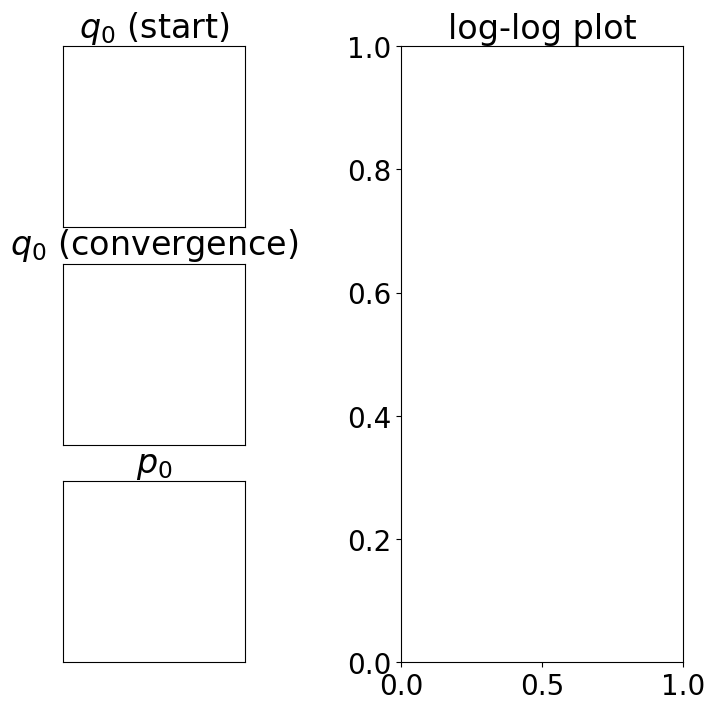

In [ ]:
#@title
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20})
fig = plt.figure(figsize = (8,8))

#add subplots
ax = fig.add_subplot(331)
ax1 = fig.add_subplot(334)
ax2 = fig.add_subplot(337)
ax3 = fig.add_subplot(122)

ax.set_xticks([])
ax.set_yticks([])
ax1.set_xticks([])
ax1.set_yticks([])
ax2.set_xticks([])
ax2.set_yticks([])
ax3.set_title('log-log plot')
ax.set_title('$q_0$ (start)')
ax1.set_title('$q_0$ (convergence)')
ax2.set_title('$p_0$')

fig.tight_layout()


Hyperparamters for training:

In [ ]:
#@title Hyperparameters
n_steps = 10
betas = make_beta_schedule(schedule='sigmoid', n_timesteps=n_steps, start=1e-5, end=1e-2)
alphas = 1 - betas
alphas_prod = torch.cumprod(alphas, 0)
alphas_prod_p = torch.cat([torch.tensor([1]).float(), alphas_prod[:-1]], 0)
alphas_bar_sqrt = torch.sqrt(alphas_prod)
one_minus_alphas_bar_log = torch.log(1 - alphas_prod)
one_minus_alphas_bar_sqrt = torch.sqrt(1 - alphas_prod)

model = ConditionalModel(n_steps)
model = model.to(DEVICE)
optimizer = optim.AdamW(model.parameters(), lr=1e-3)
dataset = train_set.data.clone().detach().float()

# dataset = torch.tensor(train_set).float()
dataset = dataset.to(DEVICE)
# Create EMA model
betas = betas.to(DEVICE)
alphas_prod = alphas_prod.to(DEVICE)
alphas = alphas.to(DEVICE)
one_minus_alphas_bar_sqrt = one_minus_alphas_bar_sqrt.to(DEVICE)
ema = EMA(0.9)
ema.register(model)

batch_size = 128
train_gen = True
epoch_start = 10
simple_losses = []
w_distances = []
w_final_distances = []

Start training:

In [ ]:
#@title Training
num_epoch = 1000
if train_gen:
    for t in range(num_epoch):
        # X is a torch Variable
        permutation = torch.randperm(dataset.size()[0])
        for i in range(0, dataset.size()[0], batch_size):
            # Retrieve current batch
            indices = permutation[i:(i + batch_size)]
            batch_x = dataset[indices].to(DEVICE)
            # plt.scatter(batch_x[:, 0], batch_x[:, 1], s=10)
            # axs[i - 1].scatter(cur_x[:, 0], cur_x[:, 1], s=10);
            # Compute the loss.
            if t<epoch_start:
                loss = -noise_estimation_2_loss(model, batch_x)
            else:
                loss = noise_estimation_2_loss(model, batch_x)
            # Before the backward pass, zero all of the network gradients
            optimizer.zero_grad()
            # Backward pass: compute gradient of the loss with respect to parameters
            loss.backward()
            # Perform gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.)
            # Calling the step function to update the parameters
            optimizer.step()
            # Update the exponential moving average
            # for p in model.parameters():
            #     p.data.clamp_(-0.1, 0.1)

            ema.update(model)
              # print(batch_x.shape)
            # print(i)
            flag = False
            if t < 35:
                flag = True
            if (i)%(batch_size*10)==0:
                flag = True
                # print(loss)
            if flag == True:

                simple_loss = 0
                for i in range(n_steps):
                    simple_loss += noise_integration_loss(model, batch_x, i).detach()
                #   compute J_SM done
                q_noise = noise_last_step(batch_x)
                # get q_T
                x_seq = p_sample_loop_from_qnoise(model, q_noise)
                # x_seq = p_sample_loop(model, batch_x.shape)
                w_distance = ot.sliced_wasserstein_distance(batch_x.detach().cpu(), x_seq[-1].detach().cpu())

                # q_seq = noise_all_step(batch_x)
                #
                # # fig, axs = plt.subplots(1, 10, figsize=(28, 3))
                # # p_noise = torch.randn(batch_x.shape)
                # w_seq = []
                # for step in range(n_steps+1):
                #     # print(step, n_steps -step)
                #     w_seq.append(ot.sliced_wasserstein_distance(q_seq[step], x_seq[n_steps - step].detach()))
                #
                # plt.plot(w_seq)
                # plt.show()
                # w_final_distance = ot.sliced_wasserstein_distance(p_noise, q_noise.detach())
                simple_losses.append(simple_loss)
                w_distances.append(w_distance)
                # # w_final_distances.append(w_final_distance)
                # # plt.scatter(x_seq[-1][:, 0].detach(), x_seq[-1][:, 1].detach(), s=5);
                # # for i in range(1, 11):
                # #     cur_x = x_seq[i * 10].detach()
                # #     axs[i - 1].scatter(cur_x[:, 0], cur_x[:, 1], s=5);
                # #     # axs[i-1].set_axis_off();
                # #     axs[i - 1].set_title('$q(\mathbf{x}_{' + str(i * 10) + '})$')
                # # plt.show()
                # # Print loss
        if t % 10 == 0:
            print(t, loss)
            # torch.save(x_seq[-1],"random.pt")
        if t == epoch_start-1:
            indices = permutation[0:(0 + 256)]
            batch_x = dataset[indices].to(DEVICE)
            q_noise = noise_last_step(batch_x).detach()
            # get q_T
            x_seq = p_sample_loop_from_qnoise(model, q_noise)
            # plt.figure(figsize=(2, 2))
            ax.scatter(x_seq[-1][:, 0].detach().cpu(), x_seq[-1][:, 1].detach().cpu(), s=1, c = "green")
            # ax2.set_xlabel("$q_0$ after maximization")
            # ax.set_xlim(-1, 1)
            # ax.set_ylim(-1, 1)
        if t == num_epoch-1:
            indices = permutation[0:(0 + 128)]
            batch_x = dataset[indices].to(DEVICE)
            q_noise = noise_last_step(batch_x).detach()
            # get q_T
            x_seq = p_sample_loop_from_qnoise(model, q_noise)
            # plt.figure(figsize=(2, 2))
            ax1.scatter(x_seq[-1][:, 0].detach().cpu(), x_seq[-1][:, 1].detach().cpu(), s=1, c = "green")
            # ax2.set_xlabel("$q_0$ after maximization")
            ax1.set_xlim(-1, 1)
            ax1.set_ylim(-1, 1)
        if t == num_epoch-1:
            num = 10
            xs = torch.linspace(0, 0.9, steps=num)
            ys = torch.linspace(0, 0.9, steps=num)
            x_0, x_1 = torch.meshgrid(xs, ys)
            x_0 = x_0.reshape(num * num, 1)
            x_1 = x_1.reshape(num * num, 1)
            input = torch.cat([x_0, x_1], 1).to(DEVICE)
            # input = batch_x
            output = torch.zeros([n_steps,input.shape[0],2]).to(DEVICE)
            for i in range(n_steps):
                # print((model(input, torch.tensor(i))/torch.sqrt((1-alphas_prod[i]))).squeeze().shape)
                output[i] = (-model(input, torch.tensor(i).to(DEVICE))/torch.sqrt((1-alphas_prod[i]))).squeeze()
            # input.requires_grad = True
            # compute maximum gradient norm:
            grad = torch.zeros([n_steps]).to(DEVICE)
            for i in range(n_steps):
                new_grad = -float('inf')
                for j in range(input.shape[0]):
                    for k in range(input.shape[0]):
                        if j != k:
                            xs = input[j]
                            ys = input[k]
                            sx = output[i,j]
                            sy = output[i,k]
                            # print(sx.shape)
                            # sy = (model(ys, torch.tensor(i))/torch.sqrt((1-alphas_prod[i]))).squeeze()
                            new_grad_new = ((sx-sy).dot(xs-ys))/((xs-ys).dot(xs-ys))
                            new_grad = max(new_grad_new, new_grad)
                grad[i] = new_grad


                # compute grad
                # new_grad = 0
                # output = torch.norm(model(input, torch.tensor(i))/torch.sqrt((1-alphas_prod[i])),dim=1)
                # for batch in range(output.shape[0]):
                #     new_grad_new = torch.norm(torch.autograd.grad(output[batch], input, retain_graph=True)[0])
                #     new_grad = max(new_grad_new, new_grad)
                # grad[i] = new_grad
            # print("max norm as upper bound L:", grad.sum(), "time", t)

0 tensor(-10.8546, grad_fn=<NegBackward0>)
10 tensor(19912948., grad_fn=<MeanBackward0>)
20 tensor(0.5200, grad_fn=<MeanBackward0>)
30 tensor(0.4911, grad_fn=<MeanBackward0>)
40 tensor(0.3448, grad_fn=<MeanBackward0>)
50 tensor(0.5197, grad_fn=<MeanBackward0>)
60 tensor(0.6684, grad_fn=<MeanBackward0>)
70 tensor(0.5502, grad_fn=<MeanBackward0>)
80 tensor(0.3860, grad_fn=<MeanBackward0>)
90 tensor(0.5644, grad_fn=<MeanBackward0>)
100 tensor(0.5639, grad_fn=<MeanBackward0>)
110 tensor(0.4236, grad_fn=<MeanBackward0>)
120 tensor(0.4037, grad_fn=<MeanBackward0>)
130 tensor(0.5760, grad_fn=<MeanBackward0>)
140 tensor(0.4741, grad_fn=<MeanBackward0>)
150 tensor(0.5116, grad_fn=<MeanBackward0>)
160 tensor(0.5022, grad_fn=<MeanBackward0>)
170 tensor(0.8501, grad_fn=<MeanBackward0>)
180 tensor(0.4214, grad_fn=<MeanBackward0>)
190 tensor(0.5088, grad_fn=<MeanBackward0>)
200 tensor(0.6825, grad_fn=<MeanBackward0>)
210 tensor(0.5203, grad_fn=<MeanBackward0>)
220 tensor(0.4486, grad_fn=<MeanBackwar

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [ ]:
#@title Estimating L_s
logits = torch.zeros(n_steps).to(DEVICE)
for i in range(n_steps):
    logits[i] = (grad[0:i+1]*betas[0:i+1]).sum() + 0.5*betas[0:i+1].sum()
its2 = torch.exp((logits))**2

In [ ]:
#@title Estimating intercept
intercept = 0.5*torch.log(2*(its2*betas).sum())
intercept

tensor(5.9092, grad_fn=<MulBackward0>)

In [ ]:
#@title Generating plots
# plt.figure(figsize=(4, 8), dpi=500)
import matplotlib
cmap = matplotlib.cm.get_cmap('Blues')
ax3.set_xlim(0, 6)
ax3.set_ylim(-4, 8)
num = len(simple_losses)-100
cc = np.linspace(0.3, 1, num)


ax3.scatter(torch.log(0.5*torch.tensor(simple_losses)[100:]), torch.log(torch.tensor(w_distances)[100:]), c=cmap(cc), s = 5, label = 'Empirical')

# print("done")
# plt.scatter(torch.tensor(simple_losses), torch.tensor(w_distances), c='y')
# plt.show()
# fs = 10
# plt.rcParams.update({'font.size': 10})
xs = torch.linspace(0., 6., steps=100)
ys = 0.5*xs + intercept.detach().cpu()
ax3.plot(xs.detach().numpy(), ys.detach().numpy(), c = 'black', label = 'Upper bound')
ax3.legend(loc = 'upper right', fontsize = 19)
# plt.title()
ax3.set_xlabel('$\log(J_{DSM})$')
ax3.set_ylabel('$\log(W(p_0, q_0))$')
# plt.savefig('4clusters.png')
# plt.show()
# print(grad)

<ipython-input-11-8b41d86a0e4c>:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('Blues')


Text(341.5865328285003, 0.5, '$\\log(W(p_0, q_0))$')

In [ ]:
#@title
indices = permutation[0:(0 + 128)]
batch_x = dataset[indices].to(DEVICE)
q_noise = noise_last_step(batch_x).detach()
# get q_T
x_seq = p_sample_loop_from_qnoise(model, q_noise)
# plt.figure(figsize=(2, 2))
ax1.scatter(x_seq[-1][:, 0].detach().cpu(), x_seq[-1][:, 1].detach().cpu(), s=1, c = "green")
# ax2.set_xlabel("$q_0$ after maximization")
ax1.set_xlim(-1, 1)
ax1.set_ylim(-1, 1)

(-1.0, 1.0)

In [ ]:
#@title
indices = permutation[0:(0 +256)]
batch_x = dataset[indices].to(DEVICE)
# q_noise = noise_last_step(batch_x).detach()
# get q_T
# x_seq = p_sample_loop_from_qnoise(model, q_noise)
# plt.figure(figsize=(2, 2))
ax2.scatter(batch_x[:, 0].detach().cpu(), batch_x[:, 1].detach().cpu(), s=1, c = "green")
# ax2.set_xlabel("$q_0$ after maximization")
ax2.set_xlim(-1, 1)
ax2.set_ylim(-1, 1)

(-1.0, 1.0)

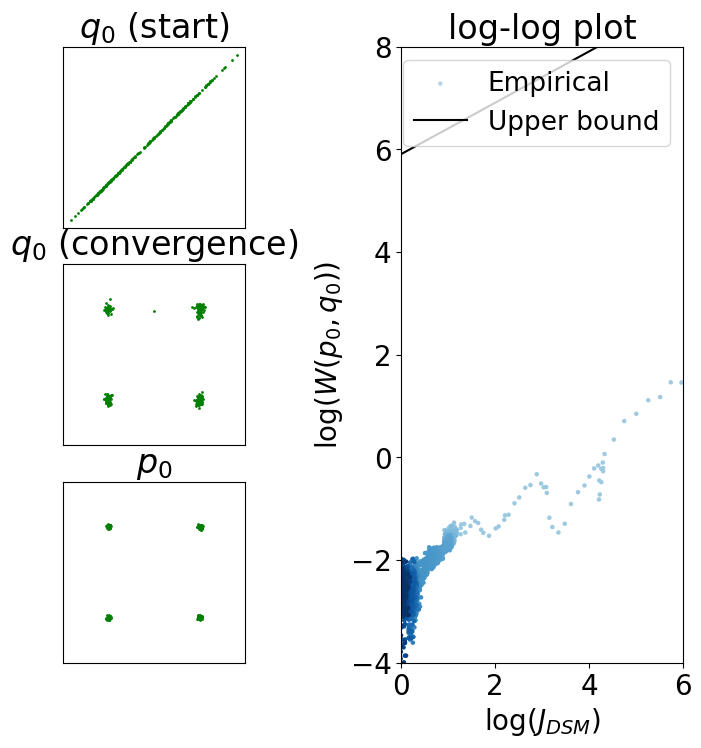

In [ ]:
#@title
fig

Text(0, 0.5, '$\\log(W(p_0, q_0))$')

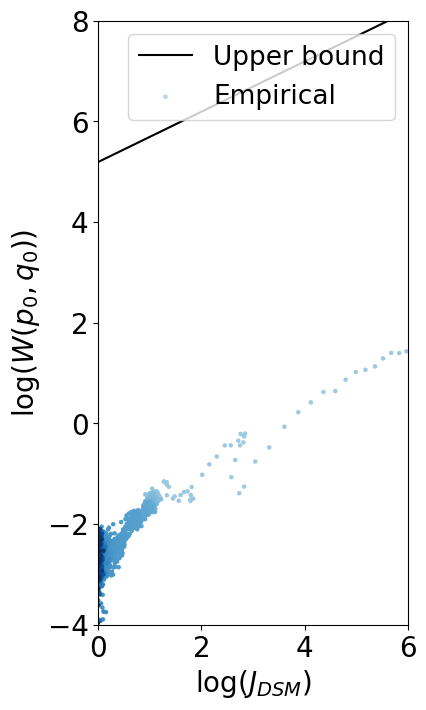

In [ ]:
#@title
import matplotlib
cmap = matplotlib.cm.get_cmap('Blues')
nfig, ax = plt.subplots(figsize = (4,8), dpi = 100)
plt.xlim(0, 6)
plt.ylim(-4, 8)
num = len(simple_losses)-100
cc = np.linspace(0.3, 1, num)


plt.scatter(torch.log(0.5*torch.tensor(simple_losses)[100:]), torch.log(torch.tensor(w_distances)[100:]), c=cmap(cc), s = 5, label = 'Empirical')

# print("done")
# plt.scatter(torch.tensor(simple_losses), torch.tensor(w_distances), c='y')
# plt.show()
# fs = 10
# plt.rcParams.update({'font.size': 10})
xs = torch.linspace(0., 6., steps=100)
ys = 0.5*xs + intercept.detach().cpu()
plt.plot(xs.detach().numpy(), ys.detach().numpy(), c = 'black', label = 'Upper bound')
plt.legend(loc = 'upper right', fontsize =19)
# plt.title()
plt.xlabel('$\log(J_{DSM})$')
plt.ylabel('$\log(W(p_0, q_0))$')